In [24]:
import json
data_root = '../data/visa/'
csv_file = 'image_anno.csv'
meta_file = 'meta.json'

paths = set()
with open(data_root+meta_file, mode='r') as file:
    data = json.load(file)
    for product_type in data['test']:
        for item in data['test'][product_type]:
            paths.add(item['img_path'])


In [25]:
to_sub_cls = {
    'normal': 'normal', 
    'scratches': 'scratch', 
    'melt': 'melt', 
    'chip around edge and corner': 'chip', 
    'different colour spot': 'spot', 
    'bubble': 'bubble', 
    'chunk of wax missing': 'missing', 
    'small chip around edge': 'chip', 
    'different color spot': 'spot', 
    'small holes': 'hole', 
    'foreign particals on candle': 'partical', 
    'fryum stuck together': 'stuck', 
    'breakage down the middle':'breakage', 
    'burnt': 'burnt', 
    'color spot similar to the object': 'spot', 
    'same colour spot': 'spot', 
    'corner and edge breakage': 'breakage', 
    'small scratches': 'scratch', 
    'damage': 'damage', 
    'chunk of gum missing': 'missing', 
    'missing': 'missing', 
    'corner missing': 'missing', 
    'stuck together': 'stuck', 
    'corner or edge breakage': 'breakage', 
    'extra': 'extra', 
    'bent': 'bent', 
    'similar colour spot': 'spot', 
    'middle breakage': 'breakage', 
    'scratch': 'scratch', 
    'wax melded out of the candle': 'melded', 
    'wrong place': 'wrong place', 
    'small cracks': 'crack', 
    'damaged corner of packaging': 'damage', 
    'weird candle wick': 'weird wick', 
    'extra wax in candle': 'extra'
 }

In [26]:
import json, csv
meta = {
    'candle':[],
    'capsules':[], 
    'cashew':[], 
    'chewinggum':[], 
    'fryum':[], 
    'macaroni1':[], 
    'macaroni2':[], 
    'pcb1':[], 
    'pcb2':[], 
    'pcb3':[], 
    'pcb4':[], 
    'pipe_fryum':[]
}
product_cls = ['candle', 'capsules', 'cashew', 'chewinggum', 'fryum', 'macaroni1', 'macaroni2', 'pcb1', 'pcb2', 'pcb3', 'pcb4', 'pipe_fryum']
defect_types = set()
for p in product_cls:
    path = data_root + p + '/' + csv_file
    with open(path, mode='r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader) 
        # Iterate over each row in the CSV file
        for row in csv_reader:
            if row[0] in paths:
                if row[1] == 'normal':
                    meta[p].append({
                        "img_path": row[0],
                        "mask_path": "",
                        "cls_name": p,
                        "anomaly": 0,
                        'defect_cls': to_sub_cls[row[1]],
                    })
                else:
                    defect = row[1].split(',')[0]
                    meta[p].append({
                        "img_path": row[0],
                        "mask_path": row[2],
                        "cls_name": p,
                        "anomaly": 1,
                        "defect_cls": to_sub_cls[defect],
                    })
                    defect_types.add(to_sub_cls[defect])

with open(data_root+'meta_all.json', 'w') as file:
    json.dump(meta, file, indent=4)  # Save with indentation for readability

print(defect_types)



{'missing', 'weird wick', 'hole', 'stuck', 'bubble', 'wrong place', 'damage', 'burnt', 'crack', 'scratch', 'chip', 'melt', 'partical', 'spot', 'melded', 'extra', 'bent', 'breakage'}


## Create Meta File

In [19]:
import os
from pathlib import Path
import json
def get_folders(path):
    return [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

def get_filename_without_suffix(path):
    return [f.split('.')[0] for f in os.listdir(path)]


def get_files(path):
    return [f.name for f in Path(path).iterdir() if f.is_file()]

meta_dict = {
    'train':{},
    'test':{},
}
dataset_file = Path('../data/MAD-Sim')
folders = get_folders(dataset_file)
for product_cls in folders:
    p_test = dataset_file / product_cls / "test"
    p_train =  dataset_file / product_cls / "train"
    p_ground_truth = dataset_file / product_cls / "ground_truth"
    defect_types = get_folders(p_test)
    for defect_type in defect_types:
        files = get_filename_without_suffix(p_test / defect_type)
        for file in files:
            anomaly = 0 if defect_type == 'good' else 1
            if product_cls[2:] not in meta_dict['test']:
                meta_dict['test'][product_cls[2:]] = []
            meta_dict['test'][product_cls[2:]].append({
                "img_path": product_cls + "/test/" + defect_type + "/" + file + '.png',
                "mask_path": product_cls + "/ground_truth/" + defect_type + "/" + file + '_mask' + '.png',
                "product_cls": product_cls[2:],
                "defect_cls": defect_type,
                "anomaly": anomaly
            })

    files = get_files(p_train / "good")
    for file in files:
        if product_cls[2:] not in meta_dict['train']:
            meta_dict['train'][product_cls[2:]] = []
        meta_dict['train'][product_cls[2:]].append({
            "img_path": product_cls + "/train/" + "good/" + file,
            "mask_path": "",
            "product_cls": product_cls[2:],
            "defect_cls": "good",
            "anomaly": 0
        })
with open(dataset_file / "meta.json", "w", encoding="utf-8") as json_file:
    json.dump(meta_dict, json_file, indent=4, ensure_ascii=False)




## Real-IAD

In [5]:
import json
code2defect = {
'AK': 'pit',
'BX': 'deformation',
'CH': 'abrasion',
'HS': 'scratch',
'PS': 'damage',
'QS': 'missing',
'YW': 'foreign',
'ZW': 'contamination',
}
# Open and read a JSON file
with open("/home/zho1rng/MClip/data/Real-IAD/meta.json", "r", encoding="utf-8") as file:
    data = json.load(file)  # Parses JSON into a Python dictionary

data['train'].pop('meta', None)
data['test'].pop('meta', None)
for product in data['train'].keys():
    for item in data['train'][product]:
        if item['anomaly'] == 1:
            code = item['img_path'].split('/')[1]

            item['defect_cls'] = code2defect[code]
        else:
            item['defect_cls'] = 'good'

for product in data['test'].keys():
    for item in data['test'][product]:
        if item['anomaly'] == 1:
            code = item['img_path'].split('/')[1]

            item['defect_cls'] = code2defect[code]
        else:
            item['defect_cls'] = 'good'

with open("/home/zho1rng/MClip/data/Real-IAD/meta1.json", "w", encoding="utf-8") as json_file:
    json.dump(data, json_file, indent=4, ensure_ascii=False)


In [ ]:
import json
code2defect = {
'AK': 'pit',
'BX': 'deformation',
'CH': 'abrasion',
'HS': 'scratch',
'PS': 'damage',
'QS': 'missing',
'YW': 'foreign',
'ZW': 'contamination',
}
# Open and read a JSON file
with open("/home/zho1rng/MClip/data/Real-IAD/meta.json", "r", encoding="utf-8") as file:
    data = json.load(file)  # Parses JSON into a Python dictionary

for product in data['train'].keys():
    for item in data['test'][product]:
        if item['anomaly'] == 1:
            code = item['img_path'].split('/')[1]

            item['defect_cls'] = code2defect[code]
        else:
            item['defect_cls'] = ''
        break

for product in data['test'].keys():
    for item in data['test'][product]:
        if item['anomaly'] == 1:
            code = item['img_path'].split('/')[1]

            item['defect_cls'] = code2defect[code]
        else:
            item['defect_cls'] = ''
        break

In [4]:
import json
code2defect = {
'AK': 'pit',
'BX': 'deformation',
'CH': 'abrasion',
'HS': 'scratch',
'PS': 'damage',
'QS': 'missing',
'YW': 'foreign',
'ZW': 'contamination',
}
# Open and read a JSON file
data_dict = {}
with open("/home/zho1rng/MClip/data/Real-IAD/meta1.json", "r", encoding="utf-8") as file:
    data = json.load(file)  # Parses JSON into a Python dictionary
for product in data['test'].keys():
    if product not in data_dict:
        data_dict[product] = set()
    for item in data['test'][product]:
        if item['defect_cls'] == '':
            data_dict[product].add('good')
        else:
            data_dict[product].add(item['defect_cls'])
for product in data['test'].keys():
    data_dict[product] = list(data_dict[product])
print(data_dict)


{'switch': ['good', 'missing', 'contamination', 'scratch'], 'eraser': ['good', 'contamination', 'scratch', 'missing', 'pit'], 'woodstick': ['good', 'contamination', 'scratch', 'missing', 'pit'], 'zipper': ['good', 'contamination', 'deformation', 'missing', 'damage'], 'fire_hood': ['good', 'contamination', 'scratch', 'missing', 'pit'], 'pcb': ['good', 'contamination', 'scratch', 'missing', 'foreign'], 'toothbrush': ['good', 'abrasion', 'contamination', 'missing'], 'plastic_nut': ['good', 'contamination', 'scratch', 'missing', 'pit'], 'wooden_beads': ['good', 'contamination', 'scratch', 'missing', 'pit'], 'transistor1': ['good', 'missing', 'contamination', 'deformation'], 'bottle_cap': ['good', 'contamination', 'scratch', 'missing', 'pit'], 'u_block': ['good', 'abrasion', 'contamination', 'scratch', 'missing'], 'sim_card_set': ['good', 'abrasion', 'contamination', 'scratch'], 'end_cap': ['good', 'contamination', 'scratch', 'missing', 'damage'], 'usb': ['good', 'contamination', 'deformati

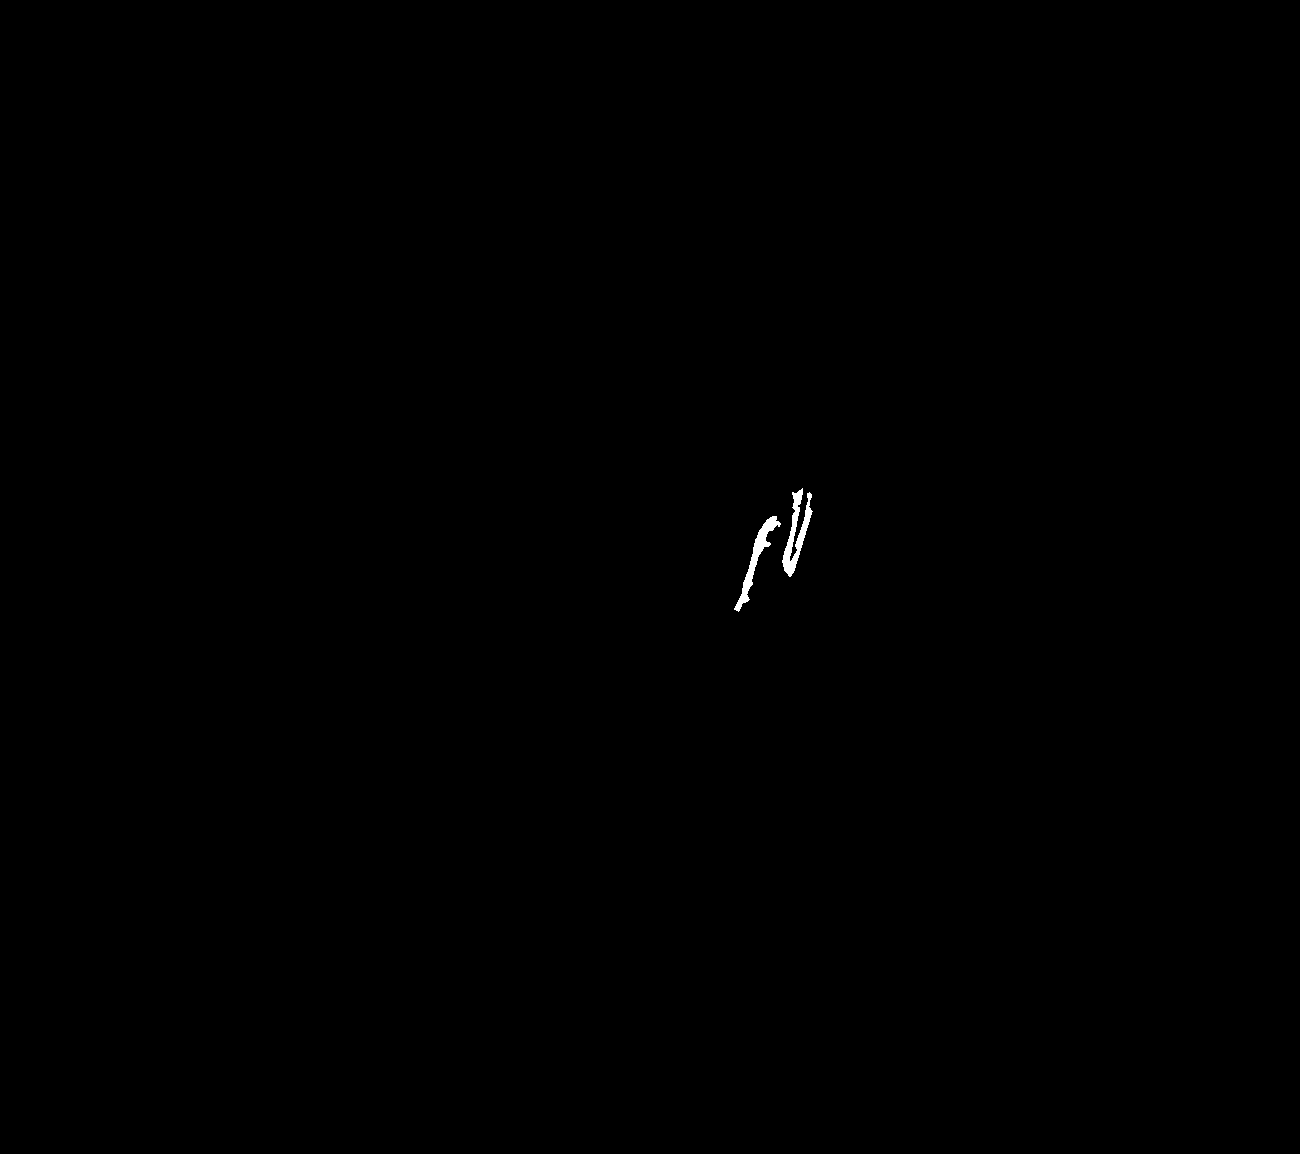

In [3]:
from PIL import Image
from IPython.display import display
import numpy as np 
# Load image
mask_path = Image.open('/home/zho1rng/MClip/data/visa/pipe_fryum/Data/Masks/Anomaly/086.png')  # Replace 'image.jpg' with your file path
img_mask = np.array(mask_path.convert('L')) > 0
img_mask = Image.fromarray(img_mask.astype(np.uint8) * 255, mode='L')
# Display image
display(img_mask)